# Data Analysis

## Setup
Import libraries, load dataframes, and get some basic information.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from typing import List
import os

from optbinning import OptimalBinning

(CVXPY) Apr 20 08:19:05 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 20 08:19:05 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
bank_churn_df = pd.read_csv("./data/ChurnForBankCustomers.csv")
# display(bank_churn_df.head())
# display(bank_churn_df.dtypes)
display(f"Number of entries is {len(bank_churn_df)} with {len(bank_churn_df.columns)} variables.")

'Number of entries is 10000 with 14 variables.'

In [3]:
# Clean up the dataframe:

# Remove RowNumber, CustomerID, Surname columns
bank_churn_df = bank_churn_df.drop(columns=["RowNumber", "CustomerId", "Surname"], errors="ignore")

# Convert HasCrCard, IsActiveMember, Exited into booleans
bank_churn_df["HasCrCard"] = bank_churn_df["HasCrCard"].astype(bool, copy=False)
bank_churn_df["IsActiveMember"] = bank_churn_df["IsActiveMember"].astype(bool, copy=False)
bank_churn_df["Exited"] = bank_churn_df["Exited"].astype(bool, copy=False)

display(bank_churn_df.head())
display(bank_churn_df.dtypes)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,True,True,101348.88,True
1,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,False
2,502,France,Female,42,8,159660.80,3,True,False,113931.57,True
3,699,France,Female,39,1,0.00,2,False,False,93826.63,False
4,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,False


CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard             bool
IsActiveMember        bool
EstimatedSalary    float64
Exited                bool
dtype: object

## Visualization
View the data distribution in each dataset.

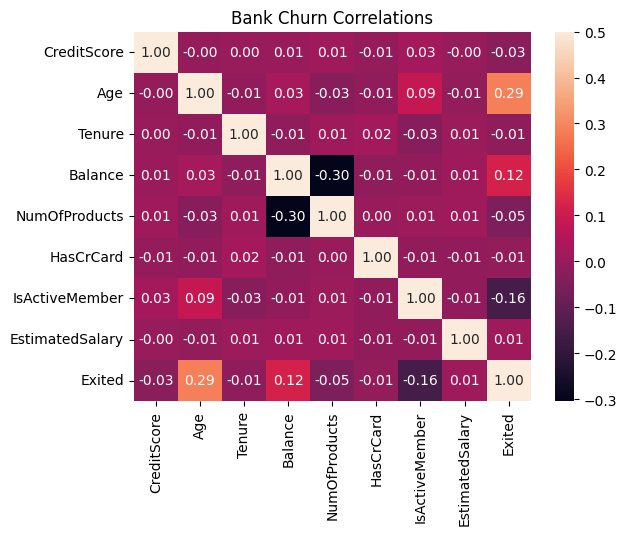

In [4]:
ax = plt.axes()

sns.heatmap(bank_churn_df.corr(numeric_only=True), annot=True, fmt=".2f", vmax="0.5", ax=ax)
ax.set_title("Bank Churn Correlations")

plt.show()

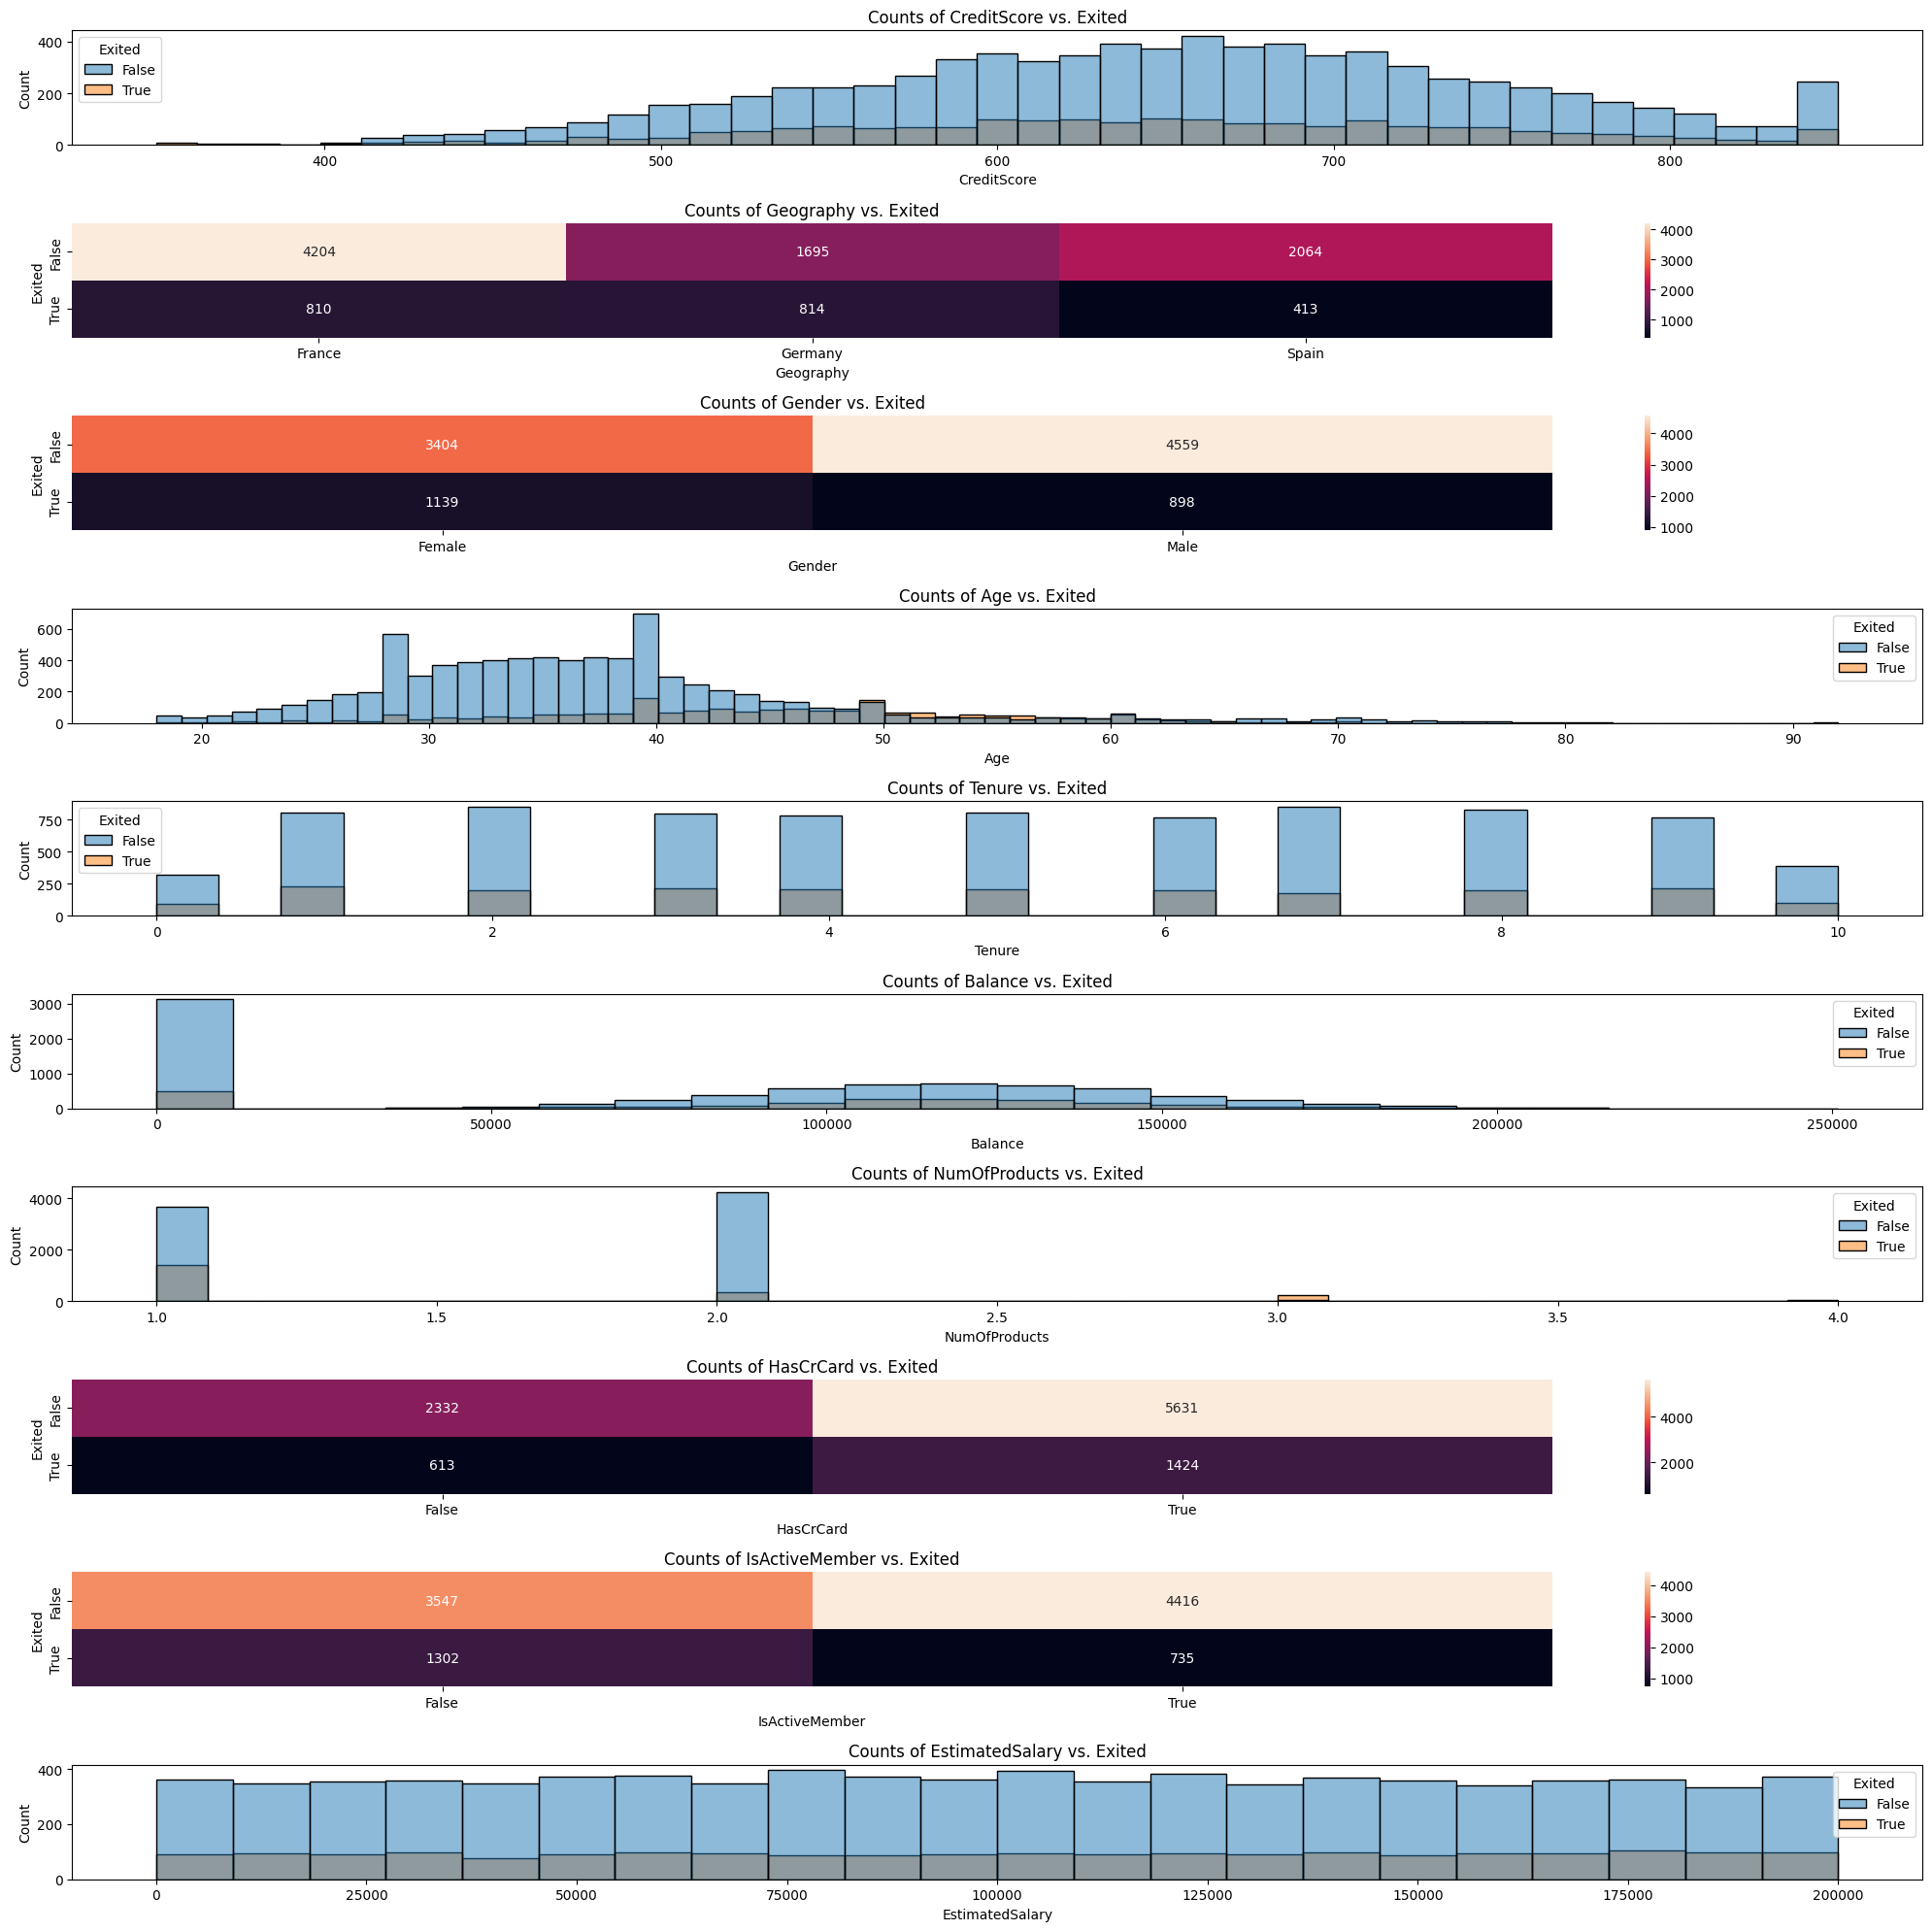

In [5]:
# Histogram for continuous variables, 2x2 count for binary variables on 'exited' column

def vis_discrete(df: pd.DataFrame, col_data: str, ax: plt.Axes, col_hue: str = "Exited") -> None:
    counts = bank_churn_df.groupby([col_data, col_hue])[col_data].size().reset_index(name="Counts")
    data = counts.pivot(index=col_hue, columns=col_data, values="Counts")
    sns.heatmap(data, fmt="d", annot=True, ax=ax)
    ax.set_title(f"Counts of {col_data} vs. {col_hue}")

def vis_continuous(df: pd.DataFrame, col_data: str, ax: plt.axes, col_hue: str = "Exited") -> None:
    sns.histplot(df, x=col_data, hue=col_hue, ax=ax)
    ax.set_title(f"Counts of {col_data} vs. {col_hue}")
    

# TODO Subplots
f, axs = plt.subplots(len(bank_churn_df.columns) - 1, 1, figsize=(20,20))

for col, ax in zip(bank_churn_df.columns, axs):
    if col == "Exited":
        pass
    elif bank_churn_df[col].dtype in ["object", "bool"]:
        vis_discrete(bank_churn_df, col, ax)
    elif bank_churn_df[col].dtype in ["int64", "float64"]:
        vis_continuous(bank_churn_df, col, ax)

f.tight_layout()
plt.show()

## Discretize Data

Discretize the data with [np.digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html) and [OptBinning](https://github.com/guillermo-navas-palencia/optbinning).


In [6]:
output_path = "/Users/nathanluskey/Library/CloudStorage/GoogleDrive-nluskey@andrew.cmu.edu/My Drive/80816_Project/Data"

continuous_columns = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary"
]

In [7]:
def my_train_test_split(df: pd.DataFrame, output_path: str, output_name: str, train_split: float = 0.8) -> None:
    train = df.sample(frac=0.8, random_state=80816)
    test = df.drop(train.index)

    train_output_name = f"{output_name}_train.csv"
    full_output = os.path.join(output_path, train_output_name)
    train.to_csv(full_output, index=False)

    test_output_name = f"{output_name}_test.csv"
    full_output = os.path.join(output_path, test_output_name)
    test.to_csv(full_output, index=False)

In [8]:
def discretize_with_binning(df: pd.DataFrame, num_bins: int, continuous_columns: List[str], output_path: str) -> None:
    # Make a deep copy
    output_df = df.copy(deep=True)

    for col in continuous_columns:
        raw_vals = df[col]
        this_num_bins = min(num_bins, len(raw_vals.unique()))
        bins = np.linspace(raw_vals.min(), raw_vals.max(), num=this_num_bins, endpoint=False)
        bin_indices = np.digitize(raw_vals, bins)
        output_df[col] = bin_indices
    
    output_name = f"ChurnForBankCustomers_{num_bins}"
    my_train_test_split(output_df, output_path, output_name)

for num_bins in [5, 10]:
    discretize_with_binning(bank_churn_df, num_bins, continuous_columns, output_path)
    

In [9]:
def discretize_with_optbinning(df: pd.DataFrame, continuous_columns: List[str], output_path: str) -> None:
    # Make a deep copy
    output_df = df.copy(deep=True)

    for col in continuous_columns:
        x = df[col].values
        y = df["Exited"].values
        optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
        optb.fit(x, y)
        bins = optb.splits
        bin_indices = np.digitize(x, bins)
        output_df[col] = bin_indices
    
    output_name = f"ChurnForBankCustomers_optbinning"
    my_train_test_split(output_df, output_path, output_name)

discretize_with_optbinning(bank_churn_df, continuous_columns, output_path)